- Because all functions are written in Jax, it is easy to obtain several derivatives of arbitrary potentials, i.e., beyond the tidal tensor. 
- This example demonstrates how higher-order derivatives can be calculated to solve variational equations. 
- Variational equations are solved along unperturbed trajectories, and we demonstrate how this integration can be performed using the CustomField class from the streamsculptor.fields module. 

In [1]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
from functools import partial

from streamsculptor import potential
from streamsculptor import JaxCoords as jc

import interpax

from astropy.constants import G

from streamsculptor import fields



Let $w = (x,v)$. We can taylor expand an orbital trajectory w/ respect to its initial condition as follows:
$$w(t_f) = w_f + \frac{dw}{dw_{\rm init}}\Delta w + \frac{1}{2} \Delta w^T \frac{d^2 w} {dw_{\rm init}^2} \Delta w + ...,$$
where derivatives are evaluated at the final time, $t_f$. The first order-term involves the tidal tensor of the potential (i.e., two derivatives of the potential):

$$ \frac{d \dot{w}}{dw_{\rm init}} = -\frac{d^2\Phi}{dw^2} \frac{dw}{dw_{\rm init}}$$



The second-order term involves the Jacobian of the tidal tensor elements themselves (i.e., three derivatives of the potential). We will remain extremely careless with notation (sorry, this calculation is best suited for index notation), but the rough idea is
$$\frac{d^2 \dot{w}}{dw^2_{\rm init}} = - \frac{d^2\Phi}{d w^2} \frac{d^2w}{dw_{\rm init}^2} - \frac{d^3 \Phi}{d w^3} \left(\frac{dw}{dw_{\rm init}} \right)^2.$$

When these equations are integrated along the unpertubed trajectory (i.e., with $\Delta w= 0$), we have solved a variational equation for the trajectory up to second order in the initial condition perturbation.

##### Why would you ever want to do that? 
Imagine you generate a sparse stream model. You can solve the variational equations of motion for each particle, and then map new initial conditions, $\Delta w$, to final conditions, $w_f$. This is a matter of matrix algebra, and does not require additional simulation (once the variational equations are solved). In principle, one could then generate extremely dense stream models, with millions of particles, rapidly.

**Below we implement an example of this approach. Taking higher-order derivatives of $\Phi$ is trivial with automatic differentation. Just define $\Phi$, let $\texttt{jax.grad}$ handle the rest.**


In [2]:
class second_order_field:
    def __init__(self, pot):
        # The background potential is the only thing we need to define the field
        self.pot = pot
        H = fields.hamiltonian_field(pot=pot) 
        # The term function is the velocity, acceleration (dw/dt)
        term_func = lambda t, xv: H.term(t,xv,None)[3:]
        term_func = jax.jit(term_func)
        # first derivative of dw/dt w/respect to w
        self.dterm_dw = jax.jit(jax.jacfwd(term_func, argnums=1))
        # second derivative of dw/dt w/respect to w
        self.d2term_dw = jax.jit(jax.jacfwd(self.dterm_dw, argnums=1))

    @partial(jax.jit, static_argnums=(0,))
    def term(self,t,coords,args):
        """
        This is the ode vector field for integrating a second order variational equation.
        self.dterm_dw is the jacobian of the acceleration with respect to the phase-space coordinates w=(x,v)
        self.d2term_dw is the jacobian of the jacobian of the acceleration with respect to the phase-space coordinates w=(x,v)
        Ultimiately we want to compute the second order variational equation:
        d/dw_init [da/dw @ dw/dw_init]
        """
        x, v = coords[0][:3], coords[0][3:]
        acceleration = -self.pot.gradient(x,t)
        xv_out = jnp.hstack([v,acceleration])

        dx_dw = coords[1][:3,:] # shape (3,6)
        dv_dw = coords[1][3:,:] # shape (3,6)
        dxv_dw = jnp.vstack([dx_dw,dv_dw]) # shape (6,6)

        d2x_dw2 = coords[2][:3,:,:] # shape (3,6,6)
        d2v_dw2 = coords[2][3:,:,:] # shape (3,6,6)
        d2xv_dw2 = jnp.vstack([d2x_dw2,d2v_dw2]) # shape (6,6,6)

        da_dw = self.dterm_dw(t,coords[0]) # shape (3,6)
        d2a_dw2 = self.d2term_dw(t,coords[0]) # shape (3,6,6)
        
        # We need to compute the matrix multiplication [da_dw]@[dxv_dw] (shape (3,6)@[6,6] = (3,6))
        da = jnp.einsum('ij,jk->ik',da_dw,dxv_dw) # shape (3,6)

        # Next we need to compute the second order term in the expansion of the acceleration
        term1 = jnp.einsum('ij,jlk->ikl',da_dw, d2xv_dw2)
        term2 = jnp.einsum('ijp,pl,jk->ikl',d2a_dw2, dxv_dw, dxv_dw)
        d2a = term1 + term2
       
        first_taylor = jnp.vstack([dv_dw, da]) # shape (6,6)
        second_taylor = jnp.vstack([d2v_dw2, d2a]) # shape (6,6,6)

        new_coords = [xv_out, first_taylor, second_taylor]
        return new_coords


pot = potential.GalaMilkyWayPotential(units=usys)
from streamsculptor.fields import CustomField 
field_obj = second_order_field(pot)
SecondOrderField = CustomField(term=field_obj.term)

In [3]:
pot = potential.GalaMilkyWayPotential(units=usys)
w0 = jnp.array([15,15.0,15.,0.1,.05,-0.1]) #jnp.array([15,15.0,15.,0.08,.05,-0.1])#
ts = jnp.linspace(-4000,0,500)  
orb = pot.integrate_orbit(w0=w0,ts=ts)
Msat = 1e4
seed_num = 194
particle_spray_direct = pot.gen_stream_scan(prog_w0=w0, ts=ts, Msat=Msat, seed_num=seed_num)

particle_spray_direct = jnp.vstack([particle_spray_direct[0],particle_spray_direct[1]])

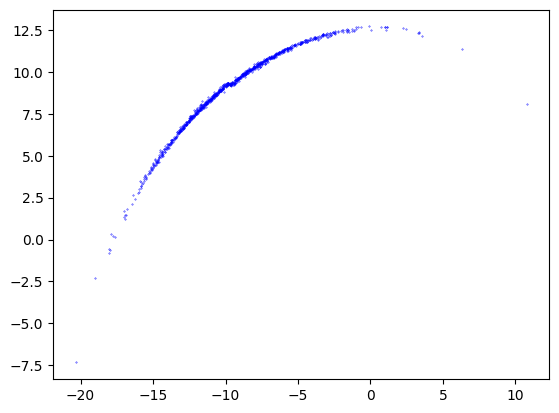

In [4]:
plt.scatter(particle_spray_direct[:,1],particle_spray_direct[:,2],s=0.1,color='blue',rasterized=True,zorder=3)

In [5]:
## get locations at stripping time
pos_close, pos_far, vel_close, vel_far = pot.gen_stream_ics(ts=ts,prog_w0=w0,Msat=Msat,seed_num=seed_num)

lead_ICs_pspray = jnp.hstack([pos_close[:-1],vel_close[:-1]])
trail_ICs_pspray = jnp.hstack([pos_far[:-1],vel_far[:-1]])

In [6]:
## Functions to generate streakline ICs
@jax.jit
def release_velocity(q_rel, q_prog, p_prog):
    r_prog_hat = q_prog/jnp.sqrt(jnp.sum(q_prog**2))
    p_prog_hat = p_prog/jnp.sqrt(jnp.sum(p_prog**2))
    sintheta = jnp.linalg.norm(jnp.cross(r_prog_hat,p_prog_hat))
    omega = pot.omega(q_prog,p_prog)
    
    p_rel = omega*jnp.sqrt(jnp.sum(q_rel**2)) / sintheta
    out = p_rel*p_prog_hat
    return out

@jax.jit
def release_conditions(q_prog,p_prog,Msat,t):
    q_lead, q_trail = pot.lagrange_pts(q_prog,p_prog,Msat,t)
    p_lead = release_velocity(q_lead, q_prog, p_prog)
    p_trail = release_velocity(q_trail, q_prog, p_prog)

    return dict(lead_q=q_lead, lead_p=p_lead, 
                trail_q=q_trail, trail_p=p_trail)

## Generate streakline
@jax.jit
@partial(jax.vmap, in_axes=(0,0,None,0,None))
def gen_streakline(q_prog=None, p_prog=None, Msat=None, tstrip=None, tfinal=None):

    ICs = release_conditions(q_prog, p_prog, Msat, tstrip)
    lead = pot.integrate_orbit(w0=jnp.hstack([ICs['lead_q'],ICs['lead_p']]), ts=jnp.array([tstrip,tfinal])).ys[-1]
    trail = pot.integrate_orbit(w0=jnp.hstack([ICs['trail_q'],ICs['trail_p']]), ts=jnp.array([tstrip,tfinal])).ys[-1]
    return lead, trail

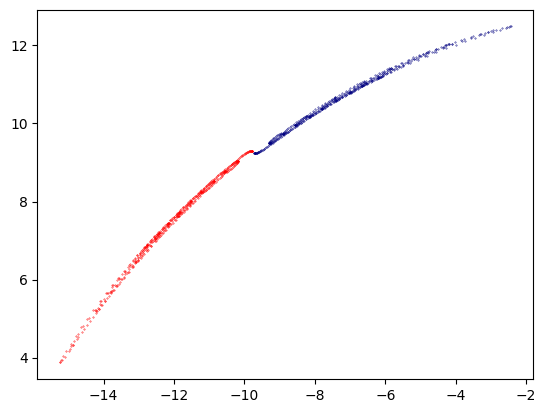

In [7]:
lead_streak, trail_streak = gen_streakline(orb.ys[:-1,:3],orb.ys[:-1,3:],Msat,ts[:-1], 0.0)

plt.scatter(lead_streak[:,1], lead_streak[:,2],color='navy', s=0.1,rasterized=True)
plt.scatter(trail_streak[:,1], trail_streak[:,2],color='r',s=0.1,rasterized=True)



In [8]:
streakline_ICs = jax.vmap(release_conditions,in_axes=(0,0,None,0))(orb.ys[:-1,:3],orb.ys[:-1,3:],Msat,ts[:-1])

lead_ICs = jnp.hstack([streakline_ICs['lead_q'],streakline_ICs['lead_p']])
trail_ICs = jnp.hstack([streakline_ICs['trail_q'],streakline_ICs['trail_p']])


delta_w_lead = lead_ICs_pspray - lead_ICs
delta_w_trail = trail_ICs_pspray - trail_ICs


In [9]:
from streamsculptor.fields import integrate_field
import diffrax
dICs_dICs = jnp.eye(6)
d2ICs_dICs = jnp.zeros((6,6,6))
d3ICs_dICs = jnp.zeros((6,6,6,6))


In [10]:
## Below we implement a scan rather than vmap
## This is because scan is more effecient on cpu than gpu

@jax.jit
def body_func(carry, t):
    idx, arm_ICs, ts = carry
    ICs = [arm_ICs[idx], dICs_dICs, d2ICs_dICs]
    t = ts[idx]
    out = integrate_field(w0=ICs,t0=t, t1=0.0, ts=jnp.array([0.0]), field=SecondOrderField,solver=diffrax.Tsit5(),atol=1e-5,rtol=1e-5,dtmin=0.5).ys
    return [idx+1, arm_ICs, ts], out

init_carry_lead = [0, lead_ICs, ts[:-1]]
init_carry_trail = [0, trail_ICs, ts[:-1]]

In [11]:
ts_stack = jnp.hstack([ts[:-1],ts[:-1]])
init_carry_total = [0, jnp.vstack([lead_ICs,trail_ICs]),ts_stack]
# Block until ready to get a sense of how long this takes
state, derivs_lead_trail = jax.block_until_ready(jax.lax.scan(body_func,init_carry_total,ts_stack))

In [12]:
derivs_lead = [derivs_lead_trail[0][:len(lead_ICs),:],derivs_lead_trail[1][:len(lead_ICs),:,:],derivs_lead_trail[2][:len(lead_ICs),:,:,:]]
derivs_trail = [derivs_lead_trail[0][len(lead_ICs):,:],derivs_lead_trail[1][len(lead_ICs):,:,:],derivs_lead_trail[2][len(lead_ICs):,:,:,:]]

dwf_dwi_lead = derivs_lead[1][:,-1,:,:]
dwf_dwi_trail = derivs_trail[1][:,-1,:,:]

d2wf_dwi2_lead = derivs_lead[2][:,-1,:,:,:]
d2wf_dwi2_trail = derivs_trail[2][:,-1,:,:,:]
d2wf_dwi2_lead.shape

(499, 6, 6, 6)

In [13]:
linear_term_lead = jnp.einsum('ijk,ik->ij',dwf_dwi_lead,delta_w_lead)
linear_term_trail = jnp.einsum('ijk,ik->ij',dwf_dwi_trail,delta_w_trail)

### Second order term: note d2wf_dwi2 is N x 6 x 6 x 6, and delta_w is N x 6
### we want to compute delta_w^T * d2wf_dwi2 * delta_w
quadratic_term_lead = jnp.einsum('ijkl,ik,il->ij',d2wf_dwi2_lead,delta_w_lead,delta_w_lead)
quadratic_term_trail = jnp.einsum('ijkl,ik,il->ij',d2wf_dwi2_trail,delta_w_trail,delta_w_trail)



meapped_lean_lin =  lead_streak + linear_term_lead
meapped_trail_lin = trail_streak + linear_term_trail

mapped_lead = meapped_lean_lin + 0.5*quadratic_term_lead
mapped_trail = meapped_trail_lin + 0.5*quadratic_term_trail


Text(-18, 15, 'Approximation')

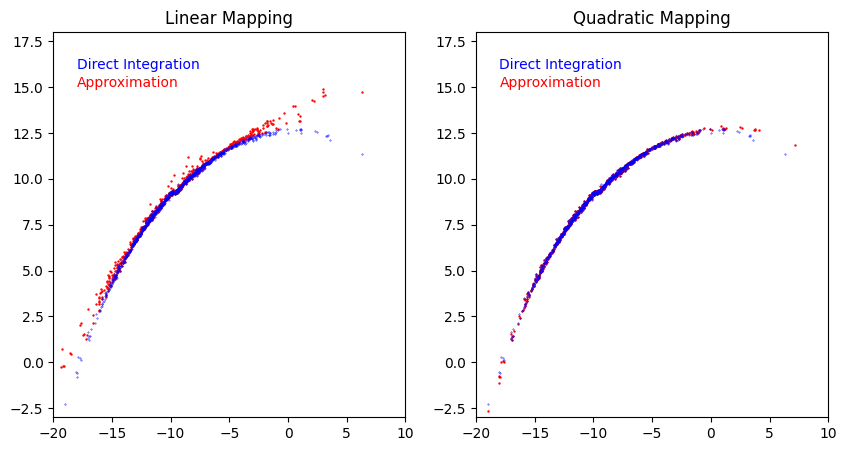

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(particle_spray_direct[:,1],particle_spray_direct[:,2],s=0.1,color='blue',rasterized=True,zorder=3)
ax[1].scatter(particle_spray_direct[:,1],particle_spray_direct[:,2],s=0.1,color='blue',rasterized=True,zorder=3)

ax[0].scatter(meapped_lean_lin[:,1], meapped_lean_lin[:,2],color='r', s=0.5,rasterized=True)
ax[0].scatter(meapped_trail_lin[:,1], meapped_trail_lin[:,2],color='r',s=0.5,rasterized=True)

ax[1].scatter(mapped_lead[:,1], mapped_lead[:,2],color='r', s=0.5,rasterized=True)
ax[1].scatter(mapped_trail[:,1], mapped_trail[:,2],color='r',s=0.5,rasterized=True)

ax[0].set_xlim(-20,10)
ax[0].set_ylim(-3,18)

ax[1].set_xlim(-20,10)
ax[1].set_ylim(-3,18)

ax[0].set_title('Linear Mapping')
ax[1].set_title('Quadratic Mapping')

ax[0].text(-18,16,'Direct Integration',color='blue')
ax[0].text(-18,15,'Approximation',color='r')

ax[1].text(-18,16,'Direct Integration',color='blue')
ax[1].text(-18,15,'Approximation',color='r')
